In [1]:
import os
from google.colab import files
import zipfile
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


In [8]:
# Установка kaggle
!pip install -q kaggle

# Создание директории для kaggle.json
!mkdir -p ~/.kaggle

# Загрузка kaggle.json
print("Загрузить kaggle.json файл.")
uploaded = files.upload()

# Перемещение kaggle.json в правильную директорию
!mv kaggle.json ~/.kaggle/

# Установка правильных разрешений
!chmod 600 ~/.kaggle/kaggle.json

# Загрузка датасета
!kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset

# Распаковка датасета
with zipfile.ZipFile("the-oxfordiiit-pet-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("oxford-iiit-pet")

print("Датасет успешно загружен и распакован в директорию 'oxford-iiit-pet'")

# Вывод списка файлов в распакованной директории
print("\nСодержимое директории 'oxford-iiit-pet':")
!ls oxford-iiit-pet

Загрузить kaggle.json файл.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset
License(s): CC-BY-SA-4.0
100% 1.47G/1.48G [01:17<00:00, 19.6MB/s]
100% 1.48G/1.48G [01:17<00:00, 20.4MB/s]
Датасет успешно загружен и распакован в директорию 'oxford-iiit-pet'

Содержимое директории 'oxford-iiit-pet':
images


In [ ]:
!rm -rf /content/oxford-iiit-pet/images/images

In [11]:
img_dir = 'oxford-iiit-pet/images'

for file in os.listdir(img_dir):
    file_path = os.path.join(img_dir, file)
    try:
        Image.open(file_path)
    except Exception as e:
        print(f"Ошибка при открытии изображения {file}: {str(e)}")
        os.remove(file_path)
        print(f"Изображение {file} удалено")

In [2]:
def load_and_preprocess_data(directory, img_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).resize((img_size, img_size))
            img = img.convert('RGB')
            img_array = np.array(img) / 255.0  # Нормализация
            images.append(img_array)
    return np.array(images)

In [3]:
# Путь к папке с изображениями
data_dir = 'oxford-iiit-pet/images'

# Размер изображений
img_size = 64
images = load_and_preprocess_data(data_dir, img_size)

# Разделение на обучающую и тестовую выборки
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

In [4]:
# Функция потерь VAE
def vae_loss(input_img, output, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(input_img, output))
    reconstruction_loss *= img_size[0] * img_size[1] * 3
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return tf.reduce_mean(reconstruction_loss + kl_loss)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Создание пользовательского слоя для вычисления функции потерь
class VAELossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        input_img, output, z_mean, z_log_var = inputs
        loss = vae_loss(input_img, output, z_mean, z_log_var)
        self.add_loss(loss)
        return output

In [5]:
# Входной слой
img_size = (64, 64)
input_img = layers.Input(shape=(img_size[0], img_size[1], 3))

# Encoder
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(input_img)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Параметры распределения
z_mean = layers.Dense(128)(x)
z_log_var = layers.Dense(128)(x)



z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(128,))
x = layers.Dense(8 * 8 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)  # Добавлен дополнительный слой
decoded = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

# Модели
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, decoded, name='decoder')
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')



# Добавление слоя для вычисления функции потерь в модель
output_with_loss = VAELossLayer()([input_img, outputs, z_mean, z_log_var])
vae_with_loss = Model(input_img, output_with_loss)

vae_with_loss.compile(optimizer='adam')

# Обучение модели
vae_with_loss.fit(train_images, train_images, epochs=100, batch_size=32, validation_data=(test_images, test_images))

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 8357.9844 - val_loss: 8109.1172
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8119.7041 - val_loss: 8076.2529
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 8050.1050 - val_loss: 8043.6914
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8037.8354 - val_loss: 8031.3418
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 8048.9888 - val_loss: 8024.6006
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8018.6919 - val_loss: 8027.8140
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8030.6460 - val_loss: 8027.3662
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8031.7666 - val_loss: 8023.7017
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8021.5508 - val_loss: 8022.7017
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8017.9043 - val_loss: 8021.4277
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss:

In [7]:
vae_with_loss.fit(train_images, train_images, epochs=100, batch_size=32, validation_data=(test_images, test_images))

Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7943.6855 - val_loss: 8062.4336
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7932.9253 - val_loss: 8069.3770
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7940.4717 - val_loss: 8068.6953
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7934.9331 - val_loss: 8067.6460
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7936.1284 - val_loss: 8064.9824
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7941.0669 - val_loss: 8064.7373
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7925.6909 - val_loss: 8068.4897
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7936.8911 - val_loss: 8066.0859
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7928.4419 - val_loss: 8077.2681
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7937.4150 - val_loss: 8075.8354
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7943.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


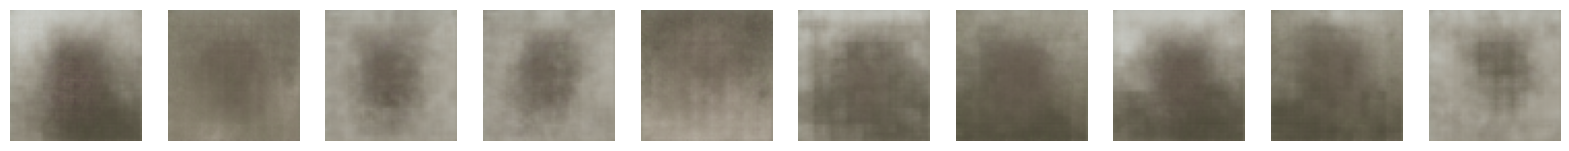

In [8]:
def generate_images(decoder, num_images=10):
    random_latent_vectors = np.random.normal(size=(num_images, 128))
    generated_images = decoder.predict(random_latent_vectors)
    return generated_images

generated_images = generate_images(decoder)


def plot_images(images, n=10):
    fig, axes = plt.subplots(1, n, figsize=(20, 2))
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

plot_images(generated_images)

In [4]:
# Путь к папке с изображениями
data_dir = 'oxford-iiit-pet/images'

images = load_and_preprocess_data(data_dir, 128)

# Разделение на обучающую и тестовую выборки
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

In [13]:
# Входной слой
img_size = (128, 128)
input_img = layers.Input(shape=(new_img_size[0], new_img_size[1], 3))

# Encoder
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(input_img)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# Параметры распределения
z_mean = layers.Dense(128)(x)
z_log_var = layers.Dense(128)(x)

# Sampling function

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(128,))
x = layers.Dense(8 * 8 * 128, activation='relu')(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)  # Добавлен дополнительный слой
decoded = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

# Модели
encoder_128 = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder_128 = Model(latent_inputs, decoded, name='decoder')
outputs = decoder_128(encoder_128(input_img)[2])
vae = Model(input_img, outputs, name='vae')

# Добавление слоя для вычисления функции потерь в модель
output_with_loss = VAELossLayer()([input_img, outputs, z_mean, z_log_var])
vae_with_loss_128 = Model(input_img, output_with_loss)

vae_with_loss_128.compile(optimizer='adam')

In [ ]:
# Обучение модели
vae_with_loss_128.fit(train_images, train_images, epochs=50, batch_size=32, validation_data=(test_images, test_images))

Не хватает памяти для обучения на изображениях 128*128, нужно было использовать генераторы с самого начала